In [1]:
import exifread
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def get_exposureTime(imgPath):
    with open(imgPath, 'rb') as f:
        tags = exifread.process_file(f, stop_tag='EXIF ExposureTime') 
    if tags:
        timeStr = str(tags['EXIF ExposureTime'].values[0])
        if len(timeStr.split('/'))==2:
            a, b = np.float32(timeStr.split('/'))
            exposureTime = a/b
        else:
            exposureTime = np.float32(timeStr)
        return exposureTime

In [3]:
def read_image(dirname):
    images = []
    exposureTimes = []

    for filename in np.sort(os.listdir(dirname)):
        if os.path.splitext(filename)[1] in ['.JPG', '.png']:
            imgPath = os.path.join(dirname, filename)
            im = cv2.imread(imgPath)
            images += [im]
            exposureTimes += [get_exposureTime(imgPath)]
    if not exposureTimes[0]: 
        exposureTimes = []
        with open(os.path.join(dirname, 'time.txt'), 'r') as f:
            lines = f.readlines()
        for line in lines:
            exposureTimes += [1/np.float(line)]
        
    return images, exposureTimes

In [4]:
def show_image(img):
    cv2.namedWindow('My Image', cv2.WINDOW_NORMAL)
    cv2.imshow('My Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
def shift_image(source, dx, dy):
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    h, w = source.shape[:2]
    result = cv2.warpAffine(source, M, (w, h))
    return result

In [6]:
def count_error(source, target, maskSrc, maskTar):
    # img1 XOR img2 AND mask
    error = np.logical_xor(source, target)
    error = np.logical_and(error, maskSrc)
    error = np.logical_and(error, maskTar)
    return np.sum(error)
    
def find_shift(source, target, x, y, thres=4):
    h, w = source.shape
    minError = np.inf
    bestX, bestY = 0, 0
    
    median = np.mean(source)
    bitSrc = cv2.inRange(source, median, median)
    maskSrc = cv2.inRange(source, median-thres, median+thres)
    
    median = np.mean(target)
    bitTar = cv2.inRange(target, median, median)
    maskTar = cv2.inRange(target, median-thres, median+thres)
    
    for dx in [0,-1,1]:
        for dy in [0,-1,1]:
            shiftSrc = shift_image(bitSrc, dx, dy)
            shiftMaskSrc = shift_image(maskSrc, dx, dy)
            
            error = count_error(shiftSrc, bitTar, maskSrc, maskTar)
            if error<minError:
                minError = error
                bestX, bestY = dx, dy
            
    return x+bestX, x+bestY

In [7]:
def align_image(source, target):
    h, w = source.shape
    
    if h<128 or w<128:
        dx, dy = find_shift(source, target, 0, 0)
    else:
        halfSrc = cv2.resize(source, (w//2, h//2))
        halfTar = cv2.resize(target, (w//2, h//2))
        prevX, prevY = align_image(halfSrc, halfTar)
        dx, dy = find_shift(source, target, prevX*2, prevY*2)
    return dx, dy

In [8]:
def gsolve(Z, B, l, w):
    '''
    Arguments:
        Z(i,j): the pixel values of pixel location number i in image j 
        B(j)  : the log delta t, or log shutter speed, for image j
        l     : lamdba, the constant that determines the amount of smoothness
        w(z)  : the weighting function value for pixel value z
        
    Returns:
        g(z)  : the log exposure corresponding to pixel value z
        lE(i) : the log film irradiance at pixel location i
    '''
    
    n = 256
    A = np.zeros((Z.shape[0]*Z.shape[1]+1+(n-2), n+Z.shape[0])) 
    b = np.zeros((A.shape[0], 1))
    
    # Include the data−fitting equations
    k = 0 
    
    for i in range(0, Z.shape[0]):
        for j in range(0, Z.shape[1]):
            wij = w[Z[i,j]]
            A[k, Z[i,j]] = wij
            A[k, n+i] = -wij
            b[k, 0] = wij*B[j]
            k+=1
    
    # Fix the curve by setting its middle value to 0
    A[k, 127] = 1
    k+=1
    
    # Include the smoothness equations
    for i in range(1, n-1):
        A[k, i-1] =    l*w[i]
        A[k, i]   = -2*l*w[i]
        A[k, i+1] =    l*w[i]
        k+=1
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:n].reshape(-1)
    lE = x[n:].reshape(-1)
    return g, lE

In [9]:
def recovered_response(images, exposureTimes):
    smallImages = deepcopy(images)
    smallRow = 10
    smallCol = 10
    
    for i in range(1, len(images)):
        img1 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(images[i-1], cv2.COLOR_BGR2GRAY)
        dx, dy = align_image(img1, img2)
        images[i] = shift_image(images[i], dx, dy) 

    for i in range(0, len(images)):
        smallImages[i] = cv2.resize(images[i], (smallRow, smallCol))

    smallImages = np.array(smallImages)
    smallImages = np.reshape(smallImages, (len(smallImages),-1,3))  # (nImage, w*h, channel)
    smallImages = np.transpose(smallImages, (1, 0, 2))              # (w*h, nImage, channel)
    
    weight = np.zeros(256)
    for i in range(256):
        weight[i] = min(i, 256-i)
        
    logTimes = np.log(exposureTimes)
    g = np.zeros((3, 256))
    lE = np.zeros((3, smallRow*smallCol))

    for channel in range(3):
        g[channel], lE[channel] = gsolve(smallImages[:,:,channel], logTimes, 50, weight)
    return g

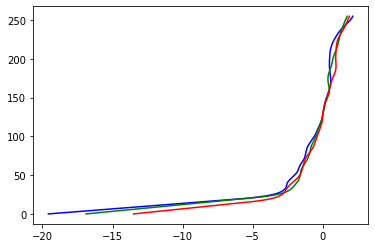

In [10]:
if __name__ == "__main__":
    images, exposureTimes = read_image('data/dataset0')
    g = recovered_response(images, exposureTimes)
    plt.figure()
    plt.plot(g[0], np.arange(256), color='b')
    plt.plot(g[1], np.arange(256), color='g')
    plt.plot(g[2], np.arange(256), color='r')
    plt.show()